<a href="https://colab.research.google.com/github/nidhisingh2309/BTP-Sem-7/blob/main/Scratch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
    # The force_remount=True argument ensures that you get a fresh authorization code.

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os
import zipfile

# Step 1: Mount Google Drive

# Step 2: Extract the zip file (if not already extracted)
zip_file_path = '/content/drive/MyDrive/Grain_img.zip'  # Path to the zip file in Drive
extract_to_folder = '/content/extracted_images'  # Folder where the images will be extracted

# Check if the images are already extracted
if not os.path.exists(extract_to_folder):
    print("Extracting zip file...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_folder)  # Extract the images to the specified folder
    print("Extraction completed.")
else:
    print(f"Folder {extract_to_folder} already exists. Skipping extraction.")

Extracting zip file...
Extraction completed.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split

# Custom generator that yields augmented image and mask batches
def custom_data_generator(image_generator, mask_generator):
    while True:
        image_batch = next(image_generator)
        mask_batch = next(mask_generator)
        mask_batch = np.expand_dims(mask_batch, axis=-1)  # Ensure mask has shape (batch_size, 256, 256, 1)
        yield (image_batch, mask_batch)

# Function to load and preprocess images
def load_data(image_folder, mask_folder, img_size=(256, 256)):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, img_size)
        mask = cv2.resize(mask, img_size)

        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        mask = np.where(mask > 0.5, 1.0, 0.0)

        image = np.expand_dims(image, axis=-1)  # Shape: (256, 256, 1)
        mask = np.expand_dims(mask, axis=-1)    # Shape: (256, 256, 1)

        images.append(image)
        masks.append(mask)

    images = np.array(images)  # Shape: (num_samples, 256, 256, 1)
    masks = np.array(masks)    # Shape: (num_samples, 256, 256, 1)

    return images, masks

# Data augmentation using ImageDataGenerator
def data_augmentation(images, masks, batch_size=16):
    image_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    mask_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    seed = 1
    image_datagen.fit(images, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)

    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)

    return custom_data_generator(image_generator, mask_generator)

# Custom weighted loss function
def weighted_binary_crossentropy(y_true, y_pred):
    boundary_weight = 5.0  # Weight for boundary pixels

    if len(y_true.shape) == 3:
        y_true = tf.expand_dims(y_true, axis=-1)  # Shape to (batch_size, 256, 256, 1)

    if len(y_pred.shape) == 3:
        y_pred = tf.expand_dims(y_pred, axis=-1)  # Shape to (batch_size, 256, 256, 1)

    weights = y_true * boundary_weight + (1.0 - y_true)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    weighted_bce = bce * tf.squeeze(weights)  # Match dimensions
    return tf.reduce_mean(weighted_bce)

# U-Net architecture
def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Shape: (batch_size, 256, 256, 1)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

# Load and preprocess data
image_folder = '/content/extracted_images/Grain_img/RG'
mask_folder = '/content/extracted_images/Grain_img/RGMask'
X, y = load_data(image_folder, mask_folder)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up model and training
model = unet_model(input_size=(256, 256, 1))
model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])

# Data augmentation for training set
train_gen = data_augmentation(X_train, y_train, batch_size=16)

# Train the model with validation data
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train) // 16,
    epochs=50,
    validation_data=(X_val, y_val)  # Validation data
)

# Evaluate model on validation data


Epoch 1/50


KeyboardInterrupt: 

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.6664 - loss: 1.6836 - val_accuracy: 0.7901 - val_loss: 0.6727
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 825ms/step - accuracy: 0.7576 - loss: 0.7732 - val_accuracy: 0.7901 - val_loss: 0.6657
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 882ms/step - accuracy: 0.7559 - loss: 0.7660 - val_accuracy: 0.7901 - val_loss: 0.6579
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 831ms/step - accuracy: 0.7580 - loss: 0.7596 - val_accuracy: 0.7901 - val_loss: 0.6643
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 833ms/step - accuracy: 0.7585 - loss: 0.7540 - val_accuracy: 0.7901 - val_loss: 0.6461
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 827ms/step - accuracy: 0.7575 - loss: 0.7499 - val_accuracy: 0.7901 - val_loss: 0.6388
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 881ms/step - accuracy: 0.7570 - loss: 0.7408 - val_accuracy: 0.7901 - val_loss: 0.6215
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 828ms/step - accuracy: 0.7569 - loss: 0.7273 - val_accura

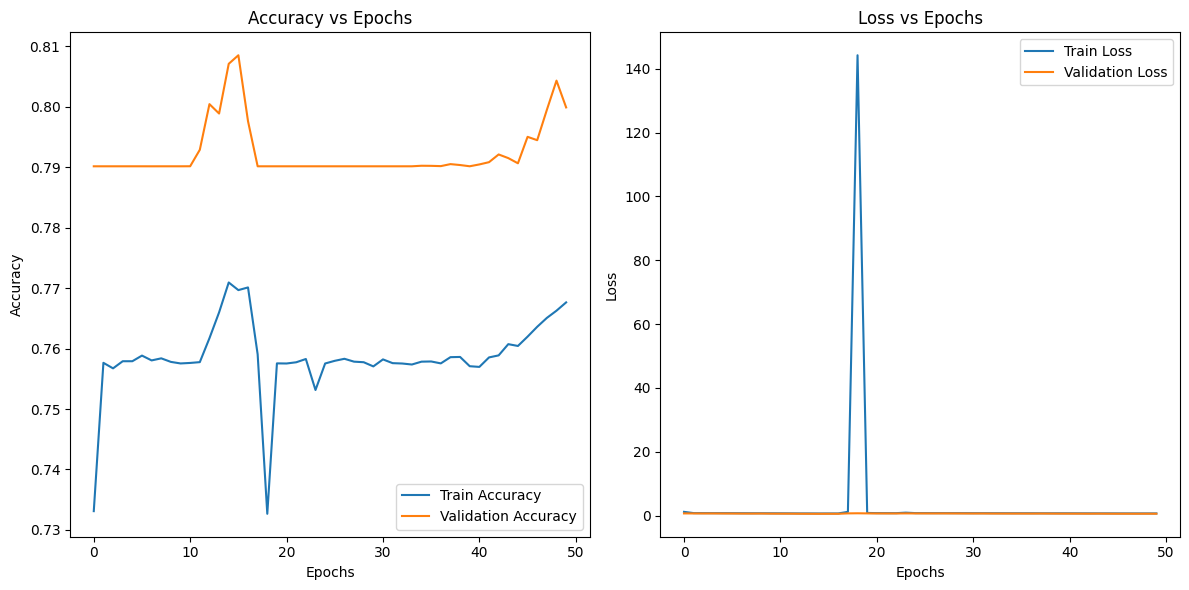

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Custom generator that yields augmented image and mask batches
def custom_data_generator(image_generator, mask_generator):
    while True:
        image_batch = next(image_generator)
        mask_batch = next(mask_generator)
        mask_batch = np.expand_dims(mask_batch, axis=-1)  # Ensure mask has shape (batch_size, 256, 256, 1)
        yield (image_batch, mask_batch)

# Function to load and preprocess images
def load_data(image_folder, mask_folder, img_size=(256, 256)):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, img_size)
        mask = cv2.resize(mask, img_size)

        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        mask = np.where(mask > 0.5, 1.0, 0.0)

        image = np.expand_dims(image, axis=-1)  # Shape: (256, 256, 1)
        mask = np.expand_dims(mask, axis=-1)    # Shape: (256, 256, 1)

        images.append(image)
        masks.append(mask)

    images = np.array(images)  # Shape: (num_samples, 256, 256, 1)
    masks = np.array(masks)    # Shape: (num_samples, 256, 256, 1)

    return images, masks

# Data augmentation using ImageDataGenerator
def data_augmentation(images, masks, batch_size=16):
    image_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    mask_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    seed = 1
    image_datagen.fit(images, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)

    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)

    return custom_data_generator(image_generator, mask_generator)

# Custom weighted loss function
def weighted_binary_crossentropy(y_true, y_pred):
    boundary_weight = 5.0  # Weight for boundary pixels

    if len(y_true.shape) == 3:
        y_true = tf.expand_dims(y_true, axis=-1)  # Shape to (batch_size, 256, 256, 1)

    if len(y_pred.shape) == 3:
        y_pred = tf.expand_dims(y_pred, axis=-1)  # Shape to (batch_size, 256, 256, 1)

    weights = y_true * boundary_weight + (1.0 - y_true)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    weighted_bce = bce * tf.squeeze(weights)  # Match dimensions
    return tf.reduce_mean(weighted_bce)

# U-Net architecture
def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Shape: (batch_size, 256, 256, 1)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

# Load and preprocess data
image_folder = '/content/extracted_images/Grain_img/RG'
mask_folder = '/content/extracted_images/Grain_img/RGMask'
X, y = load_data(image_folder, mask_folder)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up model and training
model = unet_model(input_size=(256, 256, 1))
model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])

# Data augmentation for training set
train_gen = data_augmentation(X_train, y_train, batch_size=16)

# Train the model and store the history
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train) // 16,
    epochs=50,
    validation_data=(X_val, y_val)
)

# Plot accuracy vs epochs
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 378ms/step


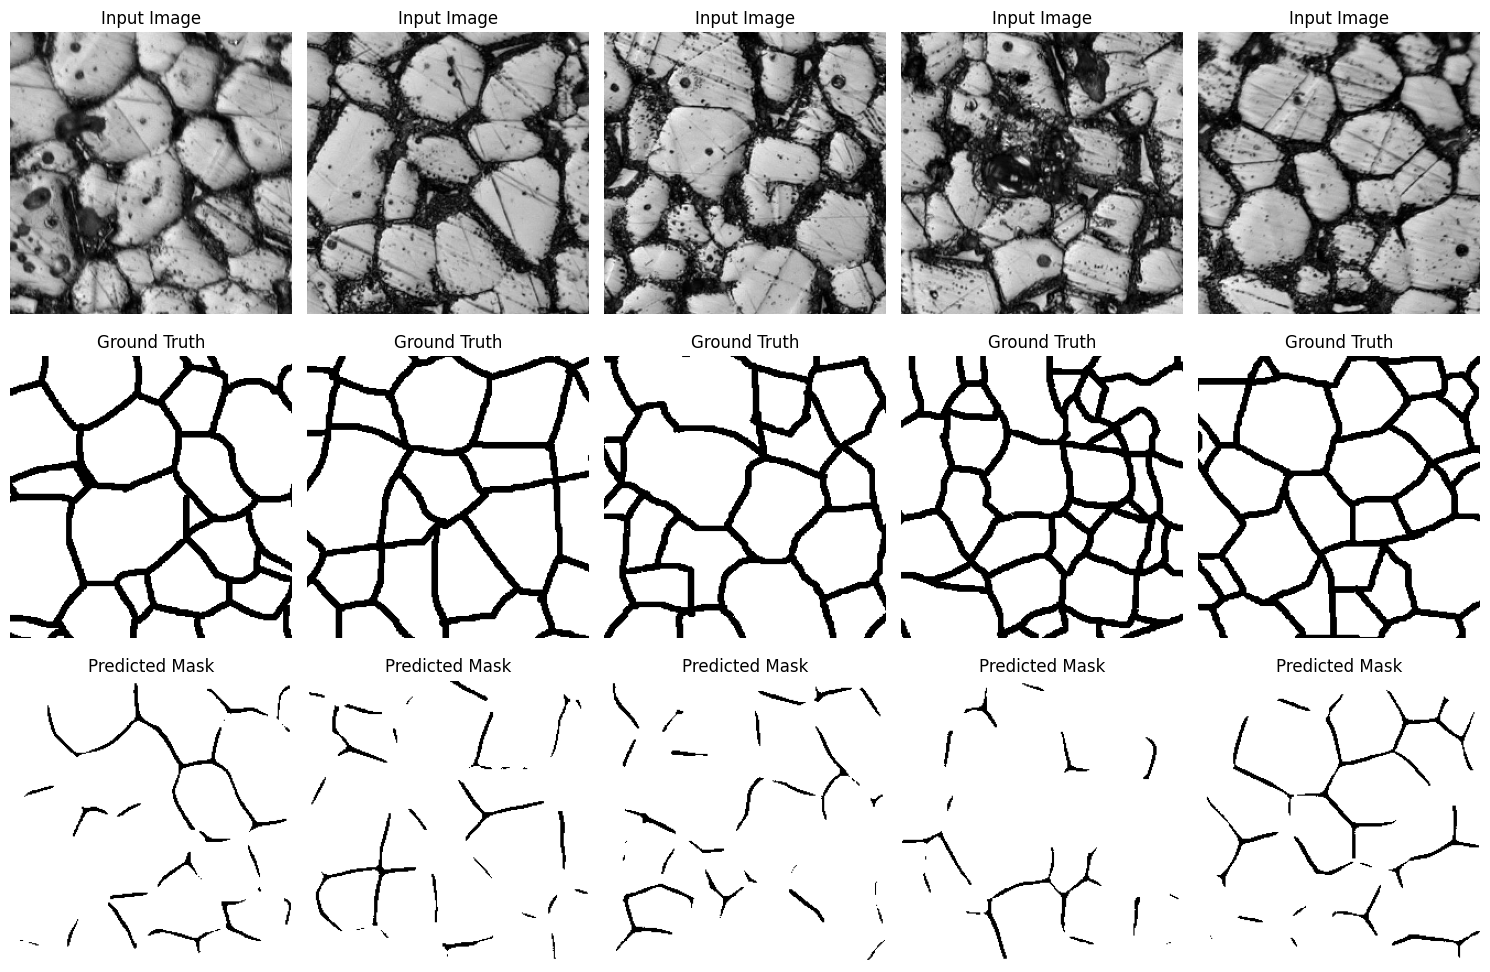

In [ ]:
# Function to predict and post-process output
import matplotlib.pyplot as plt

def predict_and_postprocess(model, X_val):
    predictions = model.predict(X_val)
    predictions = (predictions > 0.5).astype(np.uint8)  # Binarize predictions
    return predictions

# Function to plot images, labels, and predictions
def plot_results(X_val, y_val, predictions, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(X_val[i].reshape(256, 256), cmap='gray')
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(y_val[i].reshape(256, 256), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(predictions[i].reshape(256, 256), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Predict on validation set
predictions = predict_and_postprocess(model, X_val)

# Plot results
plot_results(X_val, y_val, predictions, num_images=5)

In [ ]:
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

# Modify your compile step to include this metric
model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy', dice_coefficient])


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step


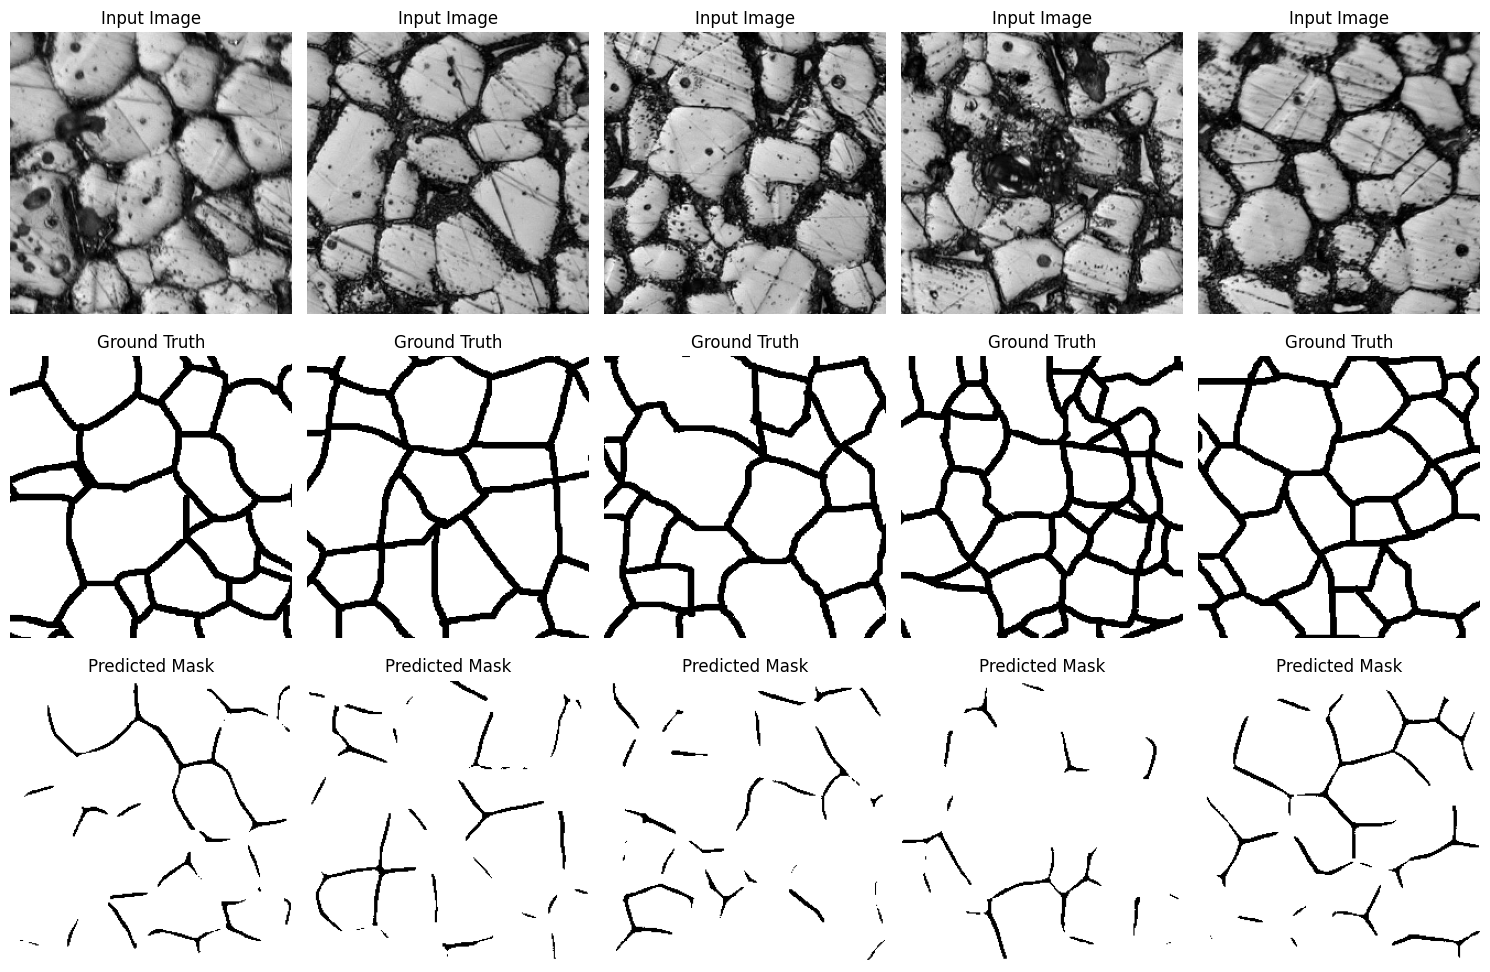

In [ ]:
# Function to predict and post-process output
import matplotlib.pyplot as plt

def predict_and_postprocess(model, X_val):
    predictions = model.predict(X_val)
    predictions = (predictions > 0.5).astype(np.uint8)  # Binarize predictions
    return predictions

# Function to plot images, labels, and predictions
def plot_results(X_val, y_val, predictions, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(X_val[i].reshape(256, 256), cmap='gray')
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(y_val[i].reshape(256, 256), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(predictions[i].reshape(256, 256), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Predict on validation set
predictions = predict_and_postprocess(model, X_val)

# Plot results
plot_results(X_val, y_val, predictions, num_images=5)